In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from itertools import chain
import os
import numpy as np
import math
import PIL
import logging
from collections import OrderedDict
from modules.internimage import *
from modules.upernet import *
from modules.dataloader import *

import os
os.getcwd()

'/blue/weishao/andresggomez/custom_internimage'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Create DataLoaders

In [3]:
# Set your dataset root path
batch_size=15
dataset_root = '/blue/weishao/andresggomez/projects/CMRI/full_internimage_format'

train_dataset = CustomDataset(dataset_root, 'images/training', 'annotations/training')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(dataset_root, 'images/validation', 'annotations/validation')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


### Define the config file for the InternImage model

In [4]:
config = Config(depths=[4, 4, 18, 4], 
                groups=[4, 8, 16, 32],
                mlp_ratio=4., 
                drop_path_rate=0.2,
                norm_layer='LN',
                layer_scale=1.0,
                offset_scale=1.0,
                post_norm=False,
                with_cp=False, 
                out_indices=(0, 1, 2, 3),
                feature_channels=[64, 128, 256, 512],
                num_labels=4)

### Define number of classes, optimizer and loss function

In [5]:
for images_train, masks_train, _ in train_loader:
    print(masks_train.shape, masks_train.dtype, torch.unique(masks_train))
    break

torch.Size([15, 4, 224, 224]) torch.float32 tensor([0., 1.])


In [6]:
# Create an instance of UperNet
num_classes = 4  

### Configure UperNet model
upernet_model = UperNet(config).to(device)

# ### Configure pretrained model
# lr = 1e-5
# num_epochs = 1200
# upernet_model.load_state_dict(torch.load(f'models/UperNet_CMRI_best_model_lr_{lr}_epochs_{num_epochs}_batch_{batch_size}.pth'))
# upernet_model.to(device)

# Set parameters to trainable 
for param in upernet_model.parameters():
    param.requires_grad_(True)
    
# Define optimizer and loss function
lr = 1e-6
optimizer = Adam(upernet_model.parameters(), 
                 lr=lr,
                 betas=(0.9, 0.999), 
                 weight_decay=0.05)

criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

2024-02-06 15:37:32,697 - mmseg - INFO - using core type: DCNv3_pytorch
2024-02-06 15:37:32,699 - mmseg - INFO - using activation layer: GELU
2024-02-06 15:37:32,700 - mmseg - INFO - using main norm layer: LN
2024-02-06 15:37:32,702 - mmseg - INFO - using dpr: linear, 0.2
2024-02-06 15:37:32,703 - mmseg - INFO - level2_post_norm: False
2024-02-06 15:37:32,705 - mmseg - INFO - level2_post_norm_block_ids: None
2024-02-06 15:37:32,706 - mmseg - INFO - res_post_norm: False


### Training loop 

In [7]:
lr = 1e-5
num_epochs = 2000

optimizer = Adam(upernet_model.parameters(), 
                 lr=lr,
                 betas=(0.9, 0.999), 
                 weight_decay=0.05)

In [8]:
# Training loop
# num_epochs = 1200
best_val_loss = float('inf')

for epoch in range(num_epochs):
    upernet_model.train()
    
    # Initialize tqdm with the number of batches in the training loader
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

    for batch_idx, (images, masks, _) in enumerate(train_loader_iter):            
        optimizer.zero_grad()

        # Move data to device
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        segmentation_outputs = upernet_model(images)

        # loss = criterion(segmentation_outputs, torch.argmax(masks, dim=1)) 
        loss = criterion(segmentation_outputs, masks) 

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update tqdm progress bar
        train_loader_iter.set_postfix({'Training Loss': loss.item()})

    # Validation loop
    upernet_model.eval()

    # Initialize tqdm with the number of batches in the validation loader
    val_loader_iter = tqdm(val_loader, desc=f'Validation', leave=False)

    with torch.no_grad():
        for val_batch, (images_val, masks_val, _) in enumerate(val_loader_iter):
            images_val, masks_val = images_val.to(device), masks_val.to(device)

            segmentation_outputs_val =  upernet_model(images_val)
            
            # val_loss = criterion(segmentation_outputs_val, torch.argmax(masks_val, dim=1))
            val_loss = criterion(segmentation_outputs_val, masks_val)

            # Update tqdm progress bar
            val_loader_iter.set_postfix({'Validation Loss': val_loss.item()})
    
    # Print final information for the epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    # # Save the model with the best validation loss
    # if val_loss.item() < best_val_loss:
    #     best_val_loss = val_loss.item()
    #     torch.save(upernet_model.state_dict(), f'models/UperNet_MOD_CMRI_lr_{lr}_epochs_{num_epochs}_batch_{batch_size}.pth')

Epoch 1/2000:   0%|          | 0/32 [00:00<?, ?it/s]/home/andresggomez/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


KeyboardInterrupt: 

In [ ]:
segmentation_outputs.shape, masks.shape

In [32]:
import matplotlib.pyplot as plt

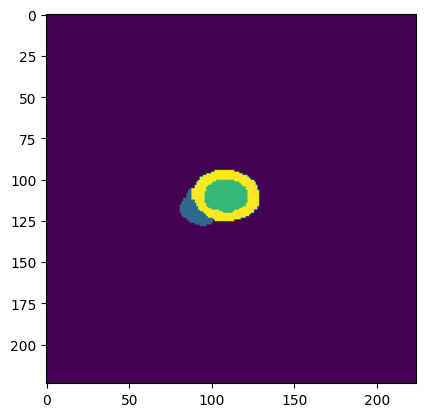

In [38]:
plt.imshow(torch.argmax(masks, dim=1).cpu().numpy()[2, :, :])

## Load in best model

In [17]:
# # Substitute with model of choice
# lr = 1e-5
# num_epochs = 1200
# upernet_model.load_state_dict(torch.load(f'models/UperNet_CMRI_best_model_lr_{lr}_epochs_{num_epochs}_batch_{batch_size}.pth'))

<All keys matched successfully>

### Calculate Average Training and Val loss

In [18]:
batch = 0
avg_train_loss = 0
for images_train, masks_train, _ in train_loader:
    images_train, masks_train = images_train.to(device), masks_train.to(device)

    segmentation_outputs_train = upernet_model(images_train)

    train_loss = criterion(segmentation_outputs_train, masks_train)
    
    avg_train_loss += train_loss.item()
    batch+=1

avg_train_loss = avg_train_loss/batch

batch = 0
avg_val_loss = 0
for images_val, masks_val, _ in val_loader:
    images_val, masks_val = images_val.to(device), masks_val.to(device)

    segmentation_outputs_val = upernet_model(images_val)

    val_loss = criterion(segmentation_outputs_val, masks_val)
    
    avg_val_loss += val_loss.item()
    batch+=1

avg_val_loss = avg_val_loss/batch


print(f'Average Cross Entropy Loss for: \nTraining set: {avg_train_loss} \nValidation set: {avg_val_loss}')

Average Cross Entropy Loss for: 
Training set: 0.03581453411607072 
Validation set: 0.03774582328540938


### Visualize Validation Set Results

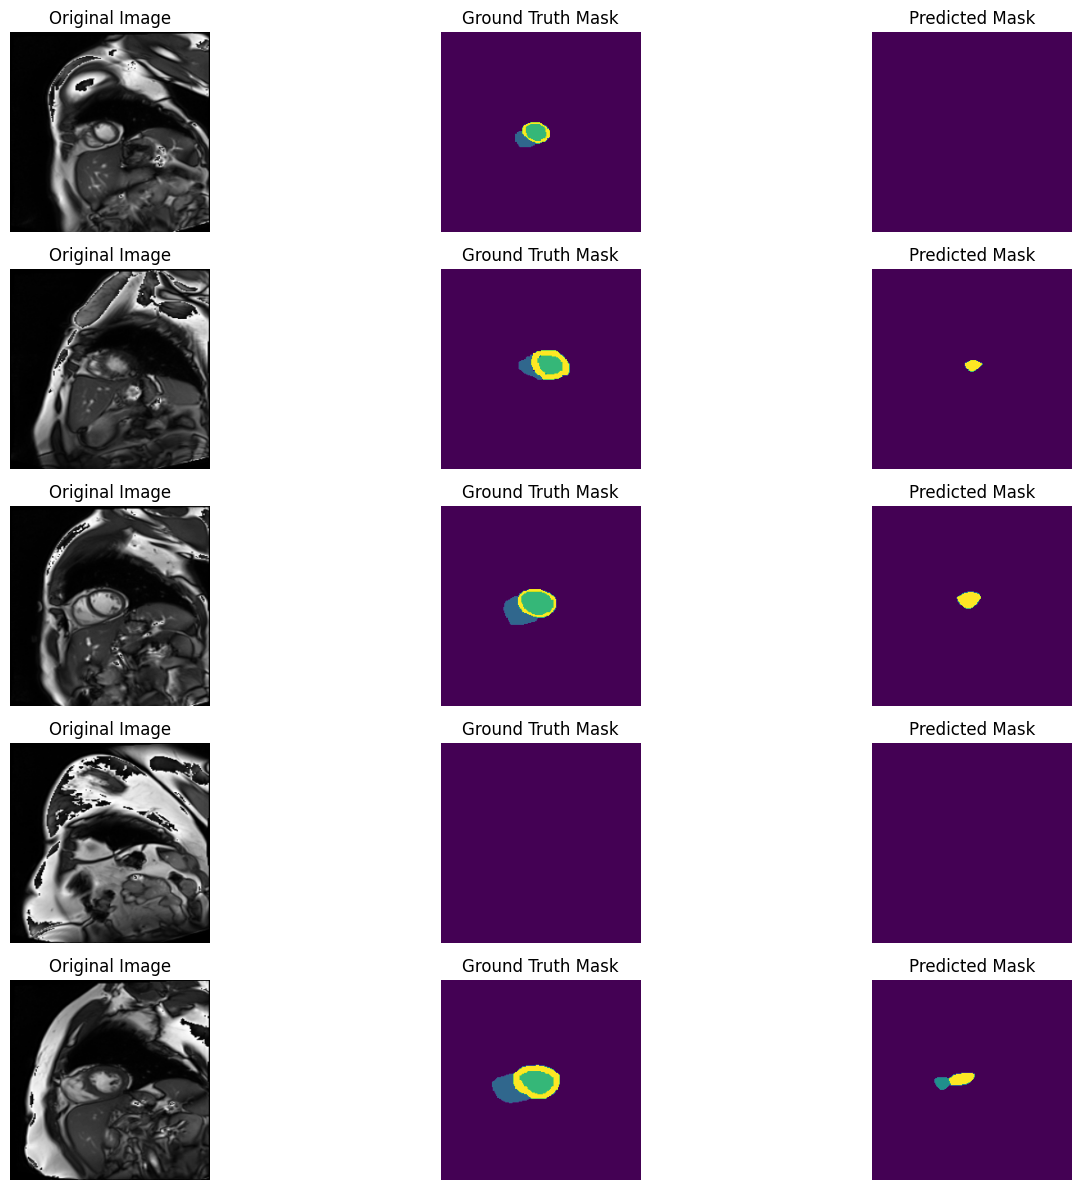

In [43]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Set the figure size and adjust layout
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

y=0
# Loop through the batch and plot images
for idx in range(5):
    # Plot the original image
    plt.subplot(5, 3, idx * 3 + 1)
    plt.imshow(images_val[idx + y, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Plot the ground truth mask
    plt.subplot(5, 3, idx * 3 + 2)
    plt.imshow(torch.argmax(masks_val, dim=1).cpu().numpy()[idx+y,:,:], cmap='viridis')  # Adjust the colormap if needed
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(5, 3, idx * 3 + 3)
    plt.imshow(torch.argmax(F.softmax(segmentation_outputs_val, dim=1), dim=1).cpu().numpy()[idx+y,:,:], cmap='viridis')
    plt.title("Predicted Mask")
    plt.axis('off')
    
# Use tight_layout to automatically adjust subplot parameters
plt.tight_layout()

# Show the plot
plt.show()
